In [11]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F


devise = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
num_epochs = 10
learning_rate = 0.001
batches = 64

In [5]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomCrop(32, padding=4),
                                transforms.Normalize((0.5,0.5,0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./cifar10',
                                             transform=transform,
                                             download=True,
                                             train=True)

test_dataset = torchvision.datasets.CIFAR10(root='/cifar10',
                                            transform=transform,
                                            download=True,
                                            train=False)

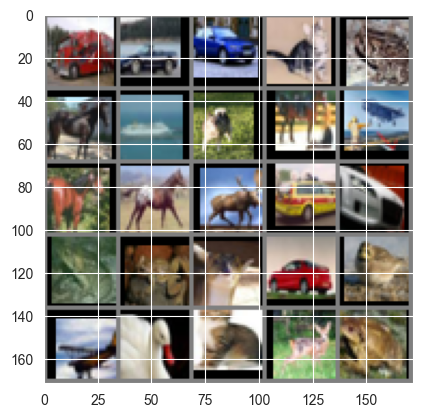

In [6]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batches,
                                           num_workers=4,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batches,
                                          shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def showimg(imgs):
    imgs = imgs / 2 + 0.5
    npimgs = imgs.numpy()
    plt.imshow(np.transpose(npimgs, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
img_grid = torchvision.utils.make_grid(images[0:25], nrow=5)
showimg(img_grid)

In [7]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.ln = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        out = self.conv(x)
        out = torch.flatten(out, 1)
        out = self.ln(out)
        return out

In [8]:

model = ConvNet()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range (num_epochs):
    sum_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):

        outputs = model(images)

        l = criterion(outputs, labels)

        l.backward()
        optimizer.step()
        optimizer.zero_grad()

        sum_loss += l

    print(f'[{epoch + 1}] loss: {sum_loss / n_total_steps:.3f}')

print('Training finished')
PATH = './CIFAR10.pth'
torch.save(model.state_dict(), PATH)

[1] loss: 1.553
[2] loss: 1.152
[3] loss: 0.984
[4] loss: 0.883
[5] loss: 0.804
[6] loss: 0.731
[7] loss: 0.680
[8] loss: 0.642
[9] loss: 0.611
[10] loss: 0.570
Training finished


In [9]:
load_model = ConvNet()
load_model.load_state_dict(torch.load(PATH))
load_model.eval()

with torch.no_grad():
    n_correct = 0
    n_samples = len(test_loader.dataset)

    for images, labels in test_loader:

        outputs = model(images)

        _, predicted = torch.max(outputs, 1)
        n_correct += (predicted == labels).sum().item()


    acc = n_correct / n_samples
    print(f'Accuracy of the network on the {n_samples} test image: {100*acc}%')

Accuracy of the network on the 10000 test image: 80.02%
